In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer
import numpy as np
from scipy.special import comb

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/doeltz/doeltz/development/RiVaPy/notebooks/models/../../rivapy/__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')
2023-01-24 13:52:29.406461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 13:52:29.406478: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Single WindPowerForecast Model

In [2]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-10] +i/(365.0*24.0) for i in range(4)]#
#forward_expiries = [timegrid[-1] + i for i in range(4)]
n_sims = 10_000
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
rnd = np.random.normal(size=wind_onshore.rnd_shape(n_sims, timegrid.shape[0]))
results = wind_onshore.simulate(timegrid, rnd, 
                                       expiries=forward_expiries, 
                                       initial_forecasts=[0.8, 0.7,0.6,0.5])


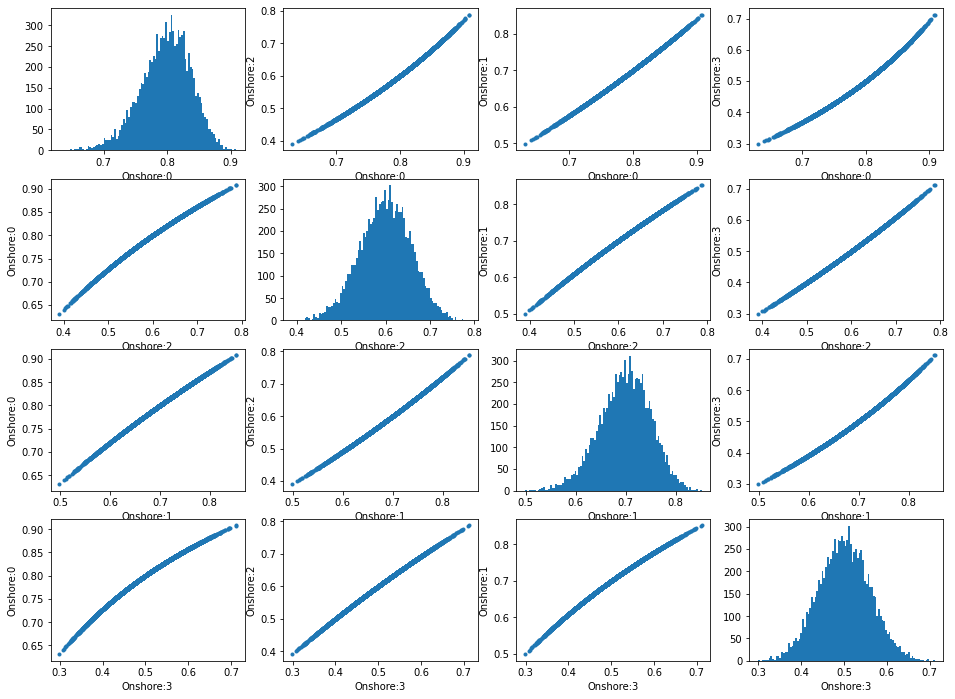

In [3]:
timepoint = -1
plt.figure(figsize=(16,12))
i=1
for k in results.keys():
    f1 = results.get(k)
    for l in results.keys():
        plt.subplot(4,4,i)
        f2 = results.get(l)
        if k==l:
            plt.hist(f1[timepoint], bins=100, label=k)
            plt.xlabel(k)
        else:
            plt.plot(f1[timepoint], f2[timepoint], '.')
            plt.xlabel(k)
            plt.ylabel(l)
        i += 1


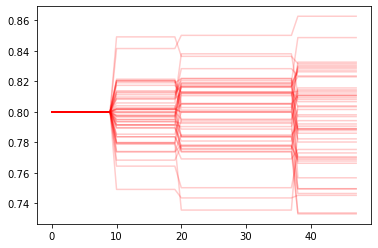

In [4]:
for k in results.keys():
    tmp = results.get(k, forecast_timepoints=[10, 20])
    for i in range(50):
        plt.plot(tmp[:,i], '-r', alpha=0.2)
    break

# Multiregion Windpower Model

In [24]:
#wind = wind_forecast_model.simulate(timegrid, rnd)
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

In [25]:
rnd = np.random.normal(size=wind.rnd_shape(n_sims, timegrid.shape[0]))
results = wind.simulate(timegrid, rnd, expiries=forward_expiries, 
                                       initial_forecasts={'Onshore': [0.8],
                                                          'Offshore': [0.6]}
                               )

NameError: name 'n_sims' is not defined

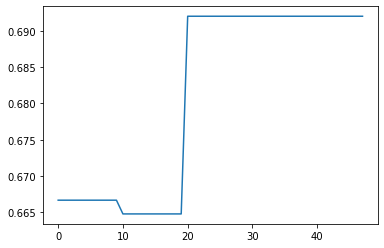

In [7]:
tmp = results.get('Wind_Germany:1', forecast_timepoints=[10, 20])
plt.plot(tmp[:,0]);

# Residual Demand Forward Model

In [45]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rd_model = ResidualDemandForwardModel(wind_power_forecast=wind, highest_price_ou_model= highest_price, 
                                      supply_curve=supply_curve, max_price=1.0, power_name= 'Power_Germany')

In [46]:
rnd = np.random.normal(size=rd_model.rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))

In [47]:
rdm_result = rd_model.simulate(timegrid, rnd, expiries=forward_expiries, initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                          'Offshore': [0.6,0.6,0.6,0.6]})

In [11]:
rdm_result.get('Power_Germany:0', forecast_timepoints=[0,1,2])

array([[0.26666667, 0.26666667, 0.26666667, ..., 0.26666667, 0.26666667,
        0.26666667],
       [0.26021478, 0.27070423, 0.26975393, ..., 0.26509957, 0.26823855,
        0.26438372],
       [0.25406328, 0.27815923, 0.27138286, ..., 0.26864876, 0.26813227,
        0.27003154],
       ...,
       [0.28389246, 0.29749926, 0.24491791, ..., 0.28798642, 0.24734741,
        0.23657972],
       [0.28392222, 0.29742968, 0.24492363, ..., 0.28800452, 0.24734926,
        0.23654951],
       [0.28392685, 0.29743316, 0.24492425, ..., 0.28804524, 0.24733697,
        0.23655771]])

In [12]:
rd_model.udls()

{'Offshore', 'Onshore', 'Power_Germany', 'Wind_Germany'}

# PPA Hedging

In [2]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)
highest_price = OrnsteinUhlenbeck(speed_of_mean_reversion=1.0, volatility=0.01, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rd_model = ResidualDemandForwardModel(wind_power_forecast=wind, highest_price_ou_model= highest_price, 
                                      supply_curve=supply_curve, max_price=1.0, power_name= 'Power_Germany')

In [3]:
val_date = dt.datetime(2023,1,1)
strike = 0.3 #0.22
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [72]:
t = -1
p=10.0
projection = np.linspace(0.1,0.4, 50)
projected_key = 'Power_Germany_FWD0'
selected = 0
#key = 'Power_Germany_FWD0'
#x = np.percentile(pricing_results.paths[key][-1,:],p)
#selected = np.abs(x-pricing_results.paths[key][-1,:]).argmin()
paths = {}
T = pricing_results.hedge_model.timegrid[-1]
ttm = (T-pricing_results.hedge_model.timegrid[t])/T
for k,v in pricing_results.paths.items():
    if k == projected_key:
        paths[k] = projection.reshape((-1,1))
    else:
        paths[k] = np.full(shape=(projection.shape[0],1), fill_value=v[t,selected])
delta = pricing_results.hedge_model.compute_delta(paths, 0.0)   


ValueError: in user code:

    File "/home/doeltz/anaconda3/envs/aifa/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/doeltz/anaconda3/envs/aifa/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/doeltz/anaconda3/envs/aifa/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/doeltz/anaconda3/envs/aifa/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/doeltz/anaconda3/envs/aifa/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/doeltz/anaconda3/envs/aifa/lib/python3.9/site-packages/keras/engine/input_spec.py", line 247, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_2" (type Functional).
    
    Input 0 of layer "dense_10" is incompatible with the layer: expected axis -1of input shape to have value 4, but received input with shape (None, 200)
    
    Call arguments received:
      • inputs=('tf.Tensor(shape=(None, 50), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)', 'tf.Tensor(shape=(None, 50), dtype=float32)')
      • training=False
      • mask=None


In [71]:
paths['Power_Germany_FWD0'].shape

(50, 1)

In [21]:
pricing_results = GreenPPADeepHedgingPricer.price(val_date, spec, rd_model, initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                          'Offshore': [0.6,0.6,0.6,0.6]},
                                                    forecast_hours=[6, 10, 14, 18],
                                                    additional_states=['Offshore'],
                                                      depth=3, nb_neurons=32, n_sims=10_000, regularization=0.0,
                                                      epochs=100, verbose=1, tensorboard_logdir = None, initial_lr=1e-3, 
                                                      batch_size=100, decay_rate=0.8, seed=42)

Epoch 1/100
100/100 [==============================] - 5s 2ms/step - loss: 4.0980e-05
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 2.9066e-06
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7301e-06
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6029e-06
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6289e-06
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7260e-06
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7998e-06
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6757e-06
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 1.8059e-06
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7442e-06
Epoch 11/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6307e-06
Epoch 12/100
100/100 [==============================

100/100 [==============================] - 0s 2ms/step - loss: 1.5930e-06
Epoch 96/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6179e-06
Epoch 97/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6659e-06
Epoch 98/100
100/100 [==============================] - 0s 2ms/step - loss: 1.7094e-06
Epoch 99/100
100/100 [==============================] - 0s 2ms/step - loss: 1.6453e-06
Epoch 100/100
100/100 [==============================] - 0s 2ms/step - loss: 1.5936e-06


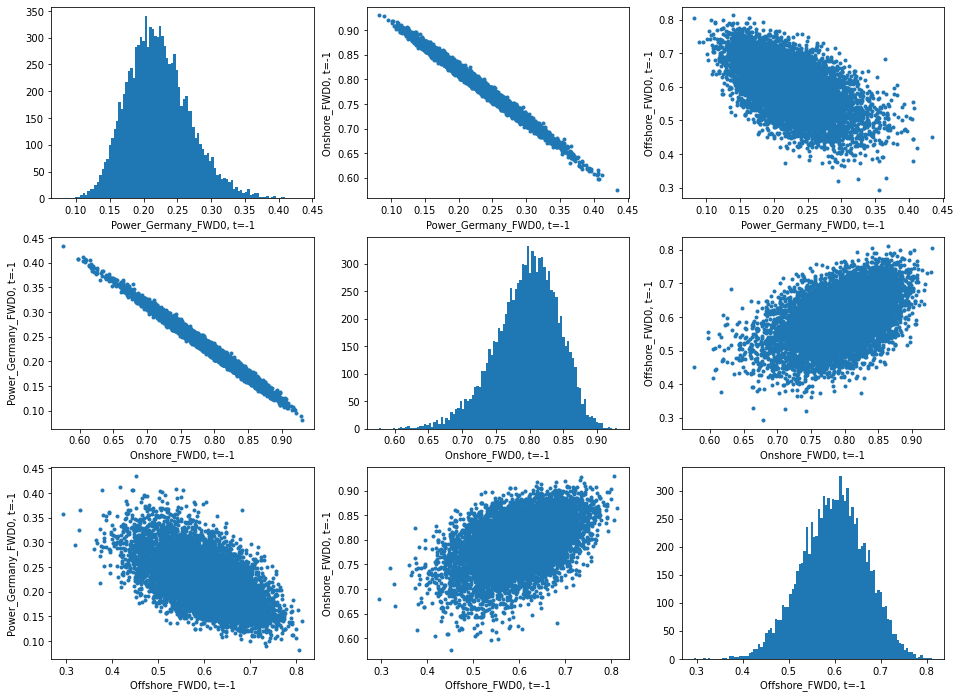

In [24]:
t = -1
plt.figure(figsize=(16,12))
n_x = 3
n_y = 3
i=1
for k,v in pricing_results.paths.items():
    for l,w in pricing_results.paths.items():
        plt.subplot(n_x,n_y,i)
        if k==l:
            plt.hist(v[t,:], bins=100)
            plt.xlabel(k+', t='+str(t))
        else:
            plt.plot(v[t,:], w[t,:], '.')
            plt.xlabel(k+', t='+str(t))
            plt.ylabel(l+', t='+str(t))
        i += 1

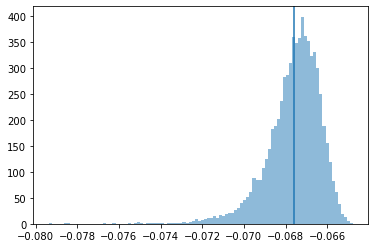

In [33]:
pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)
#plt.hist(pricing_results.payoff, bins=100, alpha=0.5, density=True)
plt.axvline(pnl.mean())
plt.hist(pnl,bins=100, alpha=0.5, density=True);

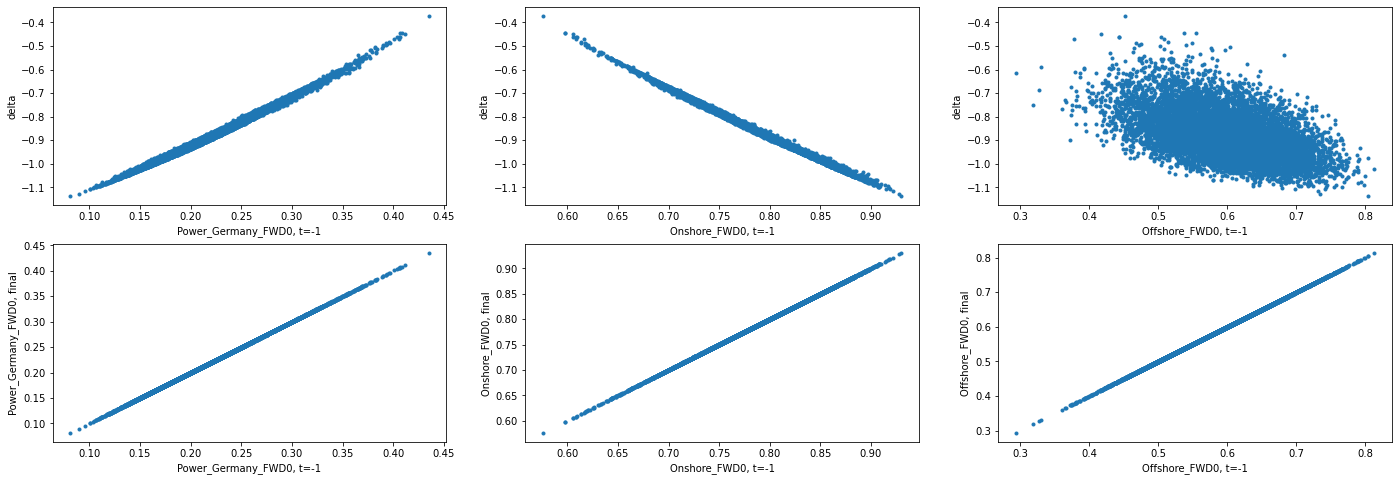

In [28]:
t = -1
n_x = 2
n_y = 3
plt.figure(figsize=(24,8))
delta = pricing_results.hedge_model.compute_delta(pricing_results.paths, t)
i=1
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], delta,'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel('delta')
    i+= 1
    
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], v[-1,:],'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel(k+', final')
    i+= 1